# Brain Tumor Detection Using Histogram of Oriented Gradient (HOG) And Support Vector Machine (SVM)

# About the Brain MRI Images dataset:

The dataset contains 2 folders: yes and no which contains  Brain MRI Images. The folder yes contains 827 Brain MRI Images
that are tumorous and the folder no contains 395 Brain MRI Images that are non-tumorous.

# Import necessary libraries

In [38]:
import numpy as np
import pandas as pd
import openpyxl
import os
import cv2
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import imutils
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Data Preparation & Preprocessing

In [39]:
tumor_dir = r'C:\Users\91817\Downloads\archive (2)\Training\yes_Tumor'
non_tumor_dir = r'C:\Users\91817\Downloads\archive (2)\Training\no_tumor'

# Initialize lists to store images and labels
images = []
labels = []

# Define the target size for resizing
target_size = (64, 64)

# Load tumor images
for filename in os.listdir(tumor_dir):
    if filename.endswith('.jpg'):
        image = cv2.imread(os.path.join(tumor_dir, filename))
        # Resize the image to the target size
        image = cv2.resize(image, target_size)
        # Perform any necessary preprocessing
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        # Call the crop_brain_contour function
        images.append(image)
        labels.append(1)  # Tumor images are labeled as 1

# Load non-tumor images
for filename in os.listdir(non_tumor_dir):
    if filename.endswith('.jpg'):
        image = cv2.imread(os.path.join(non_tumor_dir, filename))
        # Resize the image to the target size
        image = cv2.resize(image, target_size)
        # Perform any necessary preprocessing
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        # Call the crop_brain_contour function
        images.append(image)
        labels.append(0)  # Non-tumor images are labeled as 0

# Ensure that all images have the same dimensions
images = [cv2.resize(image, target_size) for image in images]

# Convert image and label lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


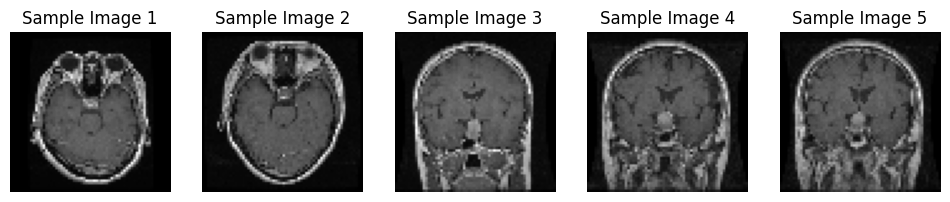

In [40]:
import matplotlib.pyplot as plt

# Select a few sample images to display
sample_images = images[:5]  # Display the first 5 images as samples

# Define a function to display the images
def display_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))

    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')

    plt.show()

# Titles for the sample images
sample_titles = ["Sample Image 1", "Sample Image 2", "Sample Image 3", "Sample Image 4", "Sample Image 5"]

# Display the sample images
display_images(sample_images, sample_titles)


In [41]:
def crop_brain_contour(image, plot=False):
    
# Convert the image to grayscale, and blur
    if len(image.shape) == 2:
        gray = image
    
    else:   
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold the image, then perform a series of erosions + dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

# Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

# At least one contour was found
    if cnts:
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

# Crop a new image out of the original image using the four extreme points (left, right, top, bottom)
        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    else:
# No contours found, return the original image
        new_image = image
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

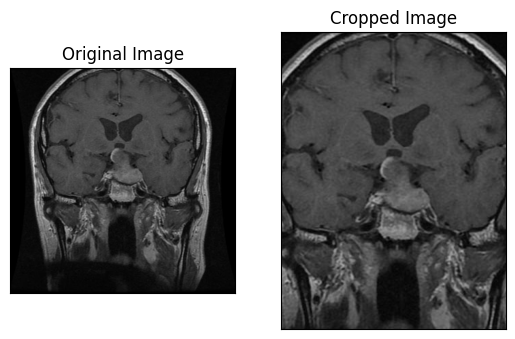

In [42]:
ex_img = cv2.imread(r'C:\Users\91817\Downloads\archive (2)\Training\yes_tumor\p (88).jpg')
ex_new_img = crop_brain_contour(ex_img, True)

# Extracting hog features

In [43]:
def extract_hog_features(images):
    features = []
    for image in images:
        # Resize and convert to grayscale if needed
        image = cv2.resize(image, (64, 64))
        if len(image.shape) == 3:  # Ensure grayscale
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Extract HOG features parameters 
        feature_vector = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
        
        #cell size, block size, block normalization
        
        features.append(feature_vector)
        # return the feature matrix
    return np.array(features)

# Define X and y based on dataset and extracted features
X = extract_hog_features(images)  # X should be the feature matrix
y = labels  # y should be the corresponding labels

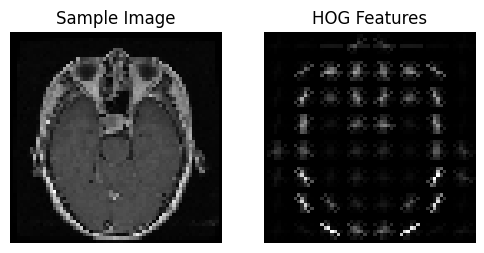

In [44]:
sample_image = images[100]

# Check if the sample image is valid and its shape contains the expected dimensions
if sample_image is not None and len(sample_image.shape) == 2 and sample_image.shape[0] > 0 and sample_image.shape[1] > 0:
    # Adjust these parameters based on image size
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)

    # Calculate HOG features
    fd, hog_image = hog(sample_image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)

    # Plot the HOG features
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
    ax1.imshow(sample_image, cmap=plt.cm.gray)
    ax1.set_title('Sample Image')
    ax1.axis('off')
    ax2.imshow(hog_image, cmap=plt.cm.gray)
    ax2.set_title('HOG Features')
    ax2.axis('off')
    plt.show()
else:
    print("Invalid sample image or dimensions.")


In [45]:
#extracting hog features in .xlsx file
hog_features = extract_hog_features(images)

# Create a DataFrame to store HOG features
data = pd.DataFrame(hog_features)

# Add labels to the DataFrame
data['Labels'] = labels

# Save the DataFrame to an Excel file
excel_file = 'hog_features.xlsx'
data.to_excel(excel_file, index=False)

print(f'HOG features saved to {excel_file}')

data.head()

HOG features saved to hog_features.xlsx


,0,1,2,3,4,5,6,7,8,9,...,1755,1756,1757,1758,1759,1760,1761,1762,1763,Labels
0,0.046667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.141545,...,0.067361,0.006429,0.007059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0.099434,0.029215,0.027257,0.040866,0.071981,0.017518,0.014160,0.000000,0.000000,0.030038,...,0.092800,0.010478,0.039917,0.066801,0.089394,0.035744,0.025015,0.010478,0.083789,1
2,0.027277,0.018087,0.013534,0.024894,0.070325,0.015072,0.022019,0.034812,0.013796,0.032521,...,0.010498,0.003769,0.012400,0.011323,0.052579,0.020895,0.006929,0.019498,0.023990,1
3,0.067036,0.047399,0.018749,0.072046,0.129830,0.042744,0.014996,0.058078,0.006348,0.037597,...,0.063819,0.010972,0.016866,0.074210,0.083891,0.053016,0.031009,0.011790,0.019243,1
4,0.023618,0.029191,0.042352,0.071796,0.050758,0.033817,0.027648,0.089340,0.000000,0.030512,...,0.040808,0.033320,0.018979,0.025305,0.057893,0.045449,0.030849,0.025456,0.040385,1


# Splitting into training and testing dataset

In [46]:
# Ensure that X is a 2D array
if len(X.shape) == 1:
    X = np.array([x.flatten() for x in X])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



X_train shape: (977, 1764)
y_train shape: (977,)


In [47]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 977
number of test examples = 245
X_train shape: (977, 1764)
Y_train shape: (977,)
X_test shape: (245, 1764)
Y_test shape: (245,)


# Implementing SVM

In [48]:
scaler = StandardScaler()

#Standardization data and involves scaling features to have a mean and standard deviation .

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for hyperparameter tuning
param_grid = {
    
    # C represents the regularization parameter in an SVM.
    'C': [0.1, 1, 10],
    
    #gamma defines how much influence each training example has in determining the shape of the decision boundary.
    'gamma': [0.001, 0.01, 0.1],
    
    #The kernel parameter specifies type of kernel function to be used in the SVM.(Radial basis function= non linear dataset)
    'kernel': ['rbf'],
}

# Create an SVM classifier
clf = GridSearchCV(svm.SVC(kernel='linear', probability=True), param_grid, cv=3)


# Hyperparameter Tuning

In [50]:
# Train the SVM with hyperparameter tuning
clf.fit(X_train, y_train)

# Get the best hyperparameters
best_params = clf.best_params_
print(f"Best hyperparameters: {best_params}")

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of class 1 (tumor)

#Evaluate the model using ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
# Evaluate the SVM model
accuracy_SVM = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_SVM * 100:.2f}%")

Best hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 98.78%


In [51]:
'''
The C parameter is the regularization parameter in an SVM.
The gamma is kernel coefficient that control shape of decision boundary
The kernel maps input data in multi-D shape, rbf (radial basis fn)
'''

'\nThe C parameter is the regularization parameter in an SVM.\nThe gamma is kernel coefficient that control shape of decision boundary\nThe kernel maps input data in multi-D shape, rbf (radial basis fn)\n'

# Implementing KNN

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Standardize the features
scaler = StandardScaler()
X_train_KNN = scaler.fit_transform(X_train)
X_test_KNN = scaler.transform(X_test)

# Define the parameter grid for hyperparameter tuning
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
}

# Create a KNN classifier
knn = KNeighborsClassifier()

# Create a GridSearchCV object
clf_KNN = GridSearchCV(knn, param_grid_KNN, cv=3)

# Fit the model
clf_KNN.fit(X_train_KNN, y_train)

# Get the best hyperparameters
best_params_KNN = clf_KNN.best_params_

# Make predictions
y_pred_KNN = clf_KNN.predict(X_test_KNN)

# Calculate accuracy
accuracy_KNN = accuracy_score(y_test, y_pred_KNN)

print("Best KNN Hyperparameters:", best_params_KNN)
print(f"Accuracy KNN: {accuracy_KNN * 100:.2f}%")


Best KNN Hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Accuracy KNN: 95.92%


# Implementing Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Standardize the features
scaler = StandardScaler()
X_train_LR = scaler.fit_transform(X_train)
X_test_LR = scaler.transform(X_test)

# Define the parameter grid for hyperparameter tuning
param_grid_LR = {
    'C': [0.1, 1, 10]
}

# Create a Logistic Regression classifier
lr = LogisticRegression()

# Create a GridSearchCV object
clf_LR = GridSearchCV(lr, param_grid_LR, cv=3)

# Fit the model
clf_LR.fit(X_train_LR, y_train)

# Get the best hyperparameters
best_params_LR = clf_LR.best_params_

# Make predictions
y_pred_LR = clf_LR.predict(X_test_LR)

# Calculate accuracy
accuracy_LR = accuracy_score(y_test, y_pred_LR)

print("Best Hyperparameters:", best_params_LR)
print(f"Accuracy LR: {accuracy_LR * 100:.2f}%")


Best Hyperparameters: {'C': 1}
Accuracy LR: 97.96%


# Implementing Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


# Define the parameter grid for hyperparameter tuning
param_grid_DT = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a Decision Tree classifier
dt = DecisionTreeClassifier()

# Create a GridSearchCV object
clf_DT = GridSearchCV(dt, param_grid_DT, cv=3)

# Fit the model
clf_DT.fit(X_train, y_train)

# Get the best hyperparameters
best_params_DT = clf_DT.best_params_

# Make predictions
y_pred_DT = clf_DT.predict(X_test)

# Calculate accuracy
accuracy_DT = accuracy_score(y_test, y_pred_DT)

print("Best Hyperparameters DT:", best_params)
print(f"Accuracy DT: {accuracy_DT * 100:.2f}%")


Best Hyperparameters DT: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy DT: 90.20%


# Implementing Naive Bayes

In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


# Standardize the features (optional for Gaussian Naive Bayes)
scaler = StandardScaler()
X_train_GNB = scaler.fit_transform(X_train)
X_test_GNB = scaler.transform(X_test)

# Create a Gaussian Naive Bayes classifier
nb = GaussianNB()

# Fit the model
nb.fit(X_train_GNB, y_train)

# Make predictions
y_pred_GNB = nb.predict(X_test_GNB)

# Calculate accuracy
accuracy_GNB = accuracy_score(y_test, y_pred_GNB)

print(f"Accuracy GNB: {accuracy_GNB * 100:.2f}%")

Accuracy GNB: 84.49%


# Comparision of Various ML Techniques

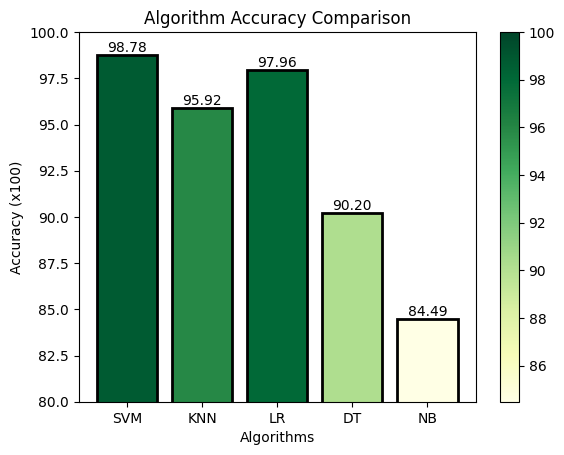

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

accuracies = [accuracy_SVM, accuracy_KNN, accuracy_LR, accuracy_DT, accuracy_GNB]
labels = ['SVM', 'KNN', 'LR', 'DT', 'NB']

# Increase the magnitude by multiplying with a constant (e.g., 100)
magnified_accuracies = [accuracy * 100 for accuracy in accuracies]

# Create a colormap based on the proximity to 100 (closer to 100, greener)
norm = Normalize(vmin=min(magnified_accuracies), vmax=100)
cmap = plt.get_cmap('YlGn')  

# Map the colors to accuracies
colors = [cmap(norm(accuracy)) for accuracy in magnified_accuracies]

# Create a figure and axis
fig, ax = plt.subplots()

# Create a bar chart to compare accuracy with color gradient
bars = ax.bar(labels, magnified_accuracies, color=colors, edgecolor='black', linewidth=2)
ax.set_xlabel('Algorithms')
ax.set_ylabel('Accuracy (x100)')
ax.set_title('Algorithm Accuracy Comparison')

# Add labels to the bars with accuracy values
for bar, v in zip(bars, magnified_accuracies):
    ax.text(bar.get_x() + bar.get_width() / 2, v, f'{v:.2f}', ha='center', va='bottom')

ax.set_ylim(80, 100)  # Set the y-axis range from 80 to 100

# Create a colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax,)

plt.show()


# Plot the ROC curve

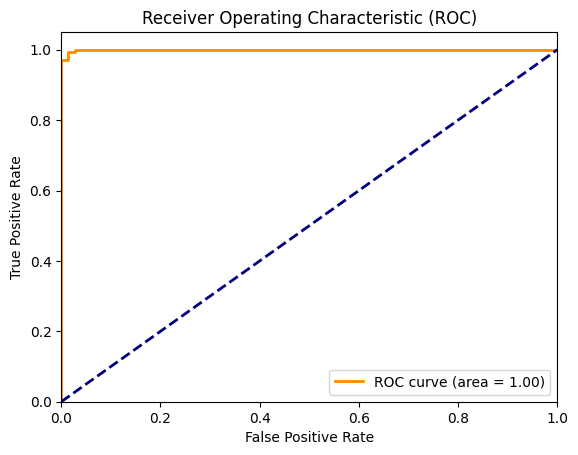

In [57]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Accuracy and FPR Calculation

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Compute accuracy and FPR
accuracy = accuracy_score(y_test, y_pred)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
true_positive = conf_matrix[1, 1]
false_positive = conf_matrix[0, 1]

# Calculate FPR (False Positive Rate)
fpr = false_positive / (false_positive + true_positive)

# Print accuracy and FPR
print("Accuracy: {:.2f}".format(accuracy))
print("False Positive Rate (FPR): {:.2f}".format(fpr))


Accuracy: 0.99
False Positive Rate (FPR): 0.02


# Fowlkes-Mallows 1 Score (F1 Score)

In [59]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

f1score = compute_f1_score(y_test, y_prob)
print(f"F1 score: {f1score}")

#true positives between 0(low precision) and 1(high precision)

F1 score: 0.9941176470588236


In [60]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [61]:
print("Training Data:")
data_percentage(y_train)

print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 977
Percentage of positive examples: 67.24667349027635%, number of pos examples: 657
Percentage of negative examples: 32.75332650972364%, number of neg examples: 320
Testing Data:
Number of examples: 245
Percentage of positive examples: 69.38775510204081%, number of pos examples: 170
Percentage of negative examples: 30.612244897959183%, number of neg examples: 75


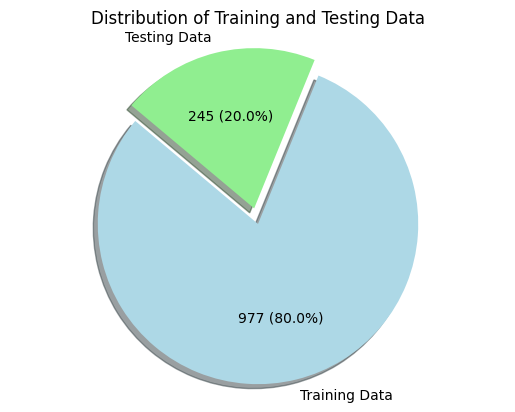

In [62]:
import matplotlib.pyplot as plt

# Data
labels = 'Training Data', 'Testing Data'print("Training Data:")
data_percentage(y_train)

print("Testing Data:")
data_percentage(y_test)
sizes = [len(y_train), len(y_test)]
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)  # Explode the first slice (Training Data)

# Create pie chart for training and testing data
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(sizes) / 100, p), shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Distribution of Training and Testing Data")
plt.show()


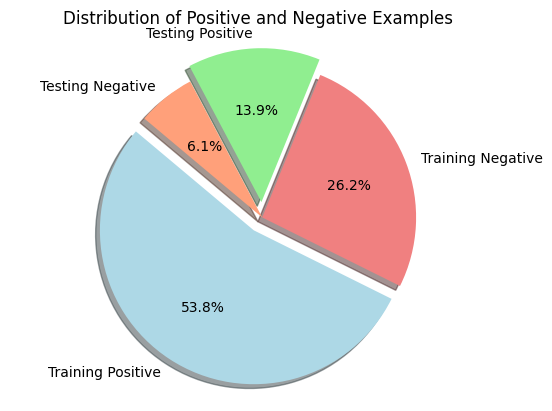

In [63]:
import matplotlib.pyplot as plt

def data_percentage(y):
    m = len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    return n_positive, n_negative

# Get the number of positive and negative examples for training and testing data
train_pos, train_neg = data_percentage(y_train)
test_pos, test_neg = data_percentage(y_test)

# Data
labels = ['Training Positive', 'Training Negative', 'Testing Positive', 'Testing Negative']
sizes = [train_pos, train_neg, test_pos, test_neg]
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon']
explode = (0.1, 0, 0.1, 0)  # Explode the Positive slices

# Create pie chart for training and testing data
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Distribution of Positive and Negative Examples")
plt.show()


# Decision Boundary Graph

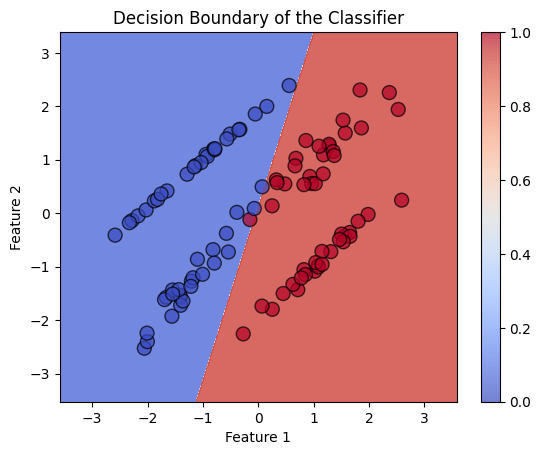

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm

# Generate a simple dataset
X, y = datasets.make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)

# Train a binary classifier (SVM)
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

# Create a mesh grid over the feature space
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Make predictions on the mesh grid
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot the data points with different colors for each class
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=100, alpha=0.7)

# Add a color bar to the right
plt.colorbar(scatter)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary of the Classifier')
plt.show()


# | F1 score  | 0.99  |   

# | Accuracy  | 99%  |
